In [1]:
import numpy as np
import os
import pandas as pd
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import colors
from matplotlib.patches import Rectangle

import scipy.io.wavfile as wav
import datetime as dt
from pathlib import Path

from torch import multiprocessing
from tqdm import tqdm

In [2]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [3]:
from src.cfg import get_config
from src.pipeline import pipeline
import src.batdt2_pipeline as batdetect2_pipeline

In [4]:
dirpath = f"{Path.home()}/Documents/UBNA/Recordings/2023_recording_season/recover-20230605/UBNA_002"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

save_dir = f'../output_dir/{recover_folder}/{audiomoth_folder}'
detfile_name = f'batdetect2_pipeline__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/UBNA/Recordings/2023_recording_season/recover-20230605/UBNA_002',
 '../output_dir/recover-20230605/UBNA_002',
 'batdetect2_pipeline__recover-20230605_UBNA_002']

In [5]:
## Each file in directory has own set of detections from 0 to file_length
## Audio file corresponding to any detection is stored in .csv output's 'input_file' column

# batdetect2_pipeline.run_pipeline(dirpath, f"{detfile_name}.csv", save_dir, f'../output/tmp')

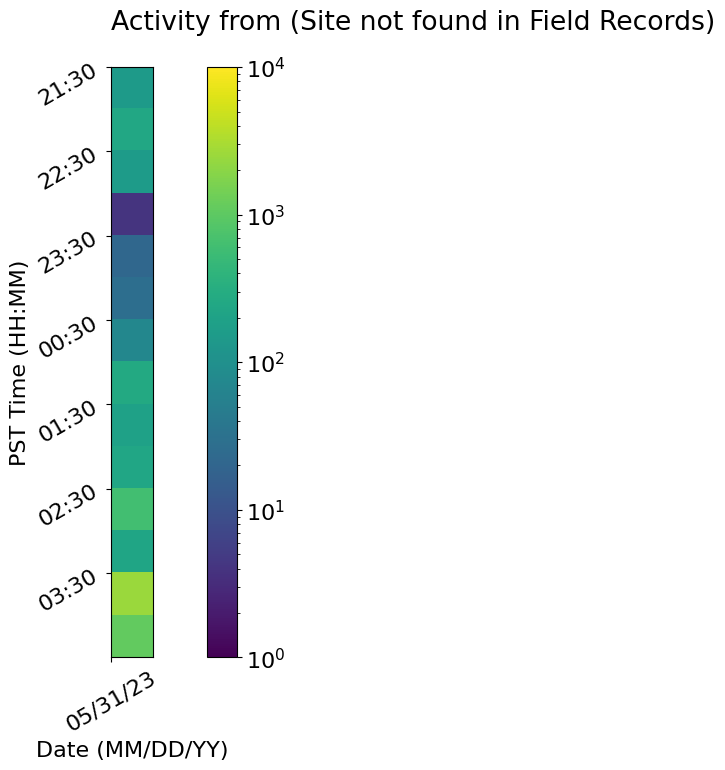

In [9]:
field_records = batdetect2_pipeline.get_field_records(Path("ubna_2022b.csv"))
site_name = batdetect2_pipeline.get_site_name(field_records, recover_date, audiomoth_unit)
batdetect2_pipeline.plot_dets_as_activity_grid(dirpath, f"{detfile_name}.csv", save_dir, site_name, show_PST=True, save=False)

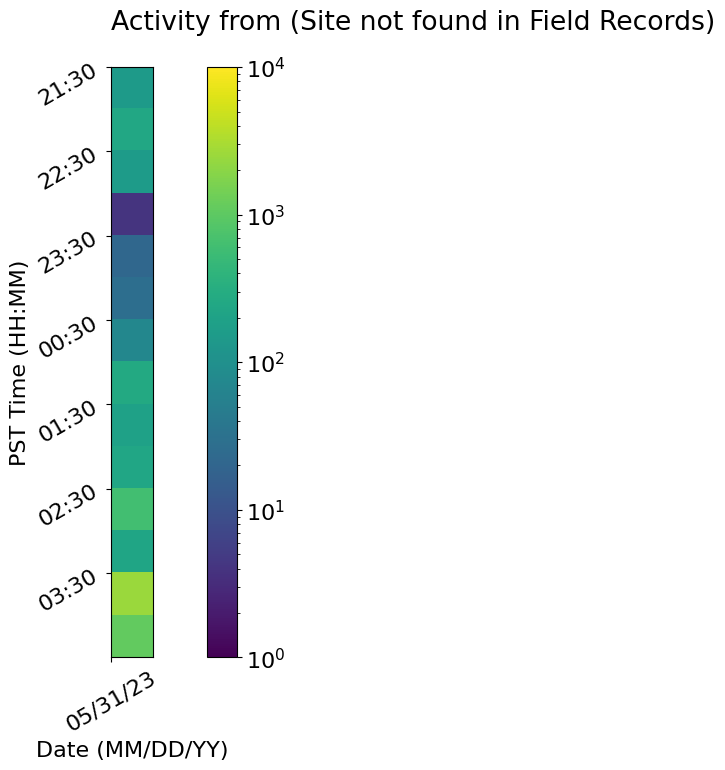

In [7]:
recover_folder = dirpath.split('/')[-2]
audiomoth_folder = dirpath.split('/')[-1]
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
activity = np.array([])
show_PST = True
activity_times = []
activity_dates = []

for file in batdetect2_pipeline.get_files_from_dir(dirpath):
    filedets = dets.loc[dets['input_file']==file.name]
    activity = np.hstack([activity, len(filedets)])

    file_dt_UTC = dt.datetime.strptime(file.name, "%Y%m%d_%H%M%S.WAV")

    if show_PST:
        if (file_dt_UTC.hour >= 7):
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        else:
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(24 + file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        if (not(activity_times.__contains__(file_time_PST))):
            activity_times.append(file_time_PST)
    else:
        file_time_UTC = dt.datetime.strftime(file_dt_UTC, "%H:%M")
        if (not(activity_times.__contains__(file_time_UTC))):
            activity_times.append(file_time_UTC)

    file_date = dt.datetime.strftime(file_dt_UTC, "%m/%d/%y")
    if (not(activity_dates.__contains__(file_date))):
        activity_dates.append(file_date)

activity = activity.reshape((len(activity_dates), len(activity_times))).T

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.title(f"Activity from {site_name}", loc='left', y=1.05)
plt.imshow(activity+1, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.yticks(np.arange(0, len(activity_times), 2)-0.5, activity_times[::2], rotation=30)
plt.xticks(np.arange(0, len(activity_dates))-0.5, activity_dates, rotation=30)
plt.ylabel('PST Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.colorbar()
plt.tight_layout()
plt.show()